In [1]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
batch_size = 100
img_height = 224
img_width = 224


In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            color_mode="rgb",
                                                            image_size=(img_height, img_width),
                                                            batch_size = 100)




Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2)
                                         ])


In [5]:
rescale = tf.keras.layers.Rescaling(1./255)


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(img_height, img_width, 3)),
                                data_augmentation,
                                rescale,
                                base_model,
                                tf.keras.layers.GlobalMaxPooling2D(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(1, activation="sigmoid")])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [8]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = tf.keras.layers.RandomFlip("horizontal")(inputs)
augmented = tf.keras.layers.RandomRotation(0.2)(augmented)

base_model = tf.keras.applications.MobileNetV2(input_tensor=augmented,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

pooling = tf.keras.layers.GlobalMaxPooling2D()(base_model.layers[-1].output)
dropout = tf.keras.layers.Dropout(0.2)(pooling)

dense_output = dropout
for i in range(2):
    dense_output =  tf.keras.layers.Dense(8, activation="relu")(dense_output)


final_output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_output)
model = tf.keras.models.Model(inputs=inputs, outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 random_rotation_1 (RandomRotat  (None, 224, 224, 3)  0          ['random_flip_1[0][0]']          
 ion)                                                                                             
                                                                                              

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [10]:
n_epochs=8
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/8
42/42 [==============================] - 139s 3s/step - loss: 0.4723 - accuracy: 0.7781 - precision: 0.8222 - recall: 0.8904 - auc: 0.8086 - val_loss: 0.5520 - val_accuracy: 0.6625 - val_precision: 0.9791 - val_recall: 0.5778 - val_auc: 0.9031
Epoch 2/8
42/42 [==============================] - 138s 3s/step - loss: 0.3202 - accuracy: 0.8488 - precision: 0.9065 - recall: 0.8855 - auc: 0.9147 - val_loss: 0.4363 - val_accuracy: 0.8054 - val_precision: 0.9810 - val_recall: 0.7642 - val_auc: 0.9271
Epoch 3/8
42/42 [==============================] - 154s 4s/step - loss: 0.2895 - accuracy: 0.8706 - precision: 0.9199 - recall: 0.9024 - auc: 0.9307 - val_loss: 0.4984 - val_accuracy: 0.7162 - val_precision: 0.9923 - val_recall: 0.6395 - val_auc: 0.9380
Epoch 4/8
42/42 [==============================] - 129s 3s/step - loss: 0.2764 - accuracy: 0.8802 - precision: 0.9337 - recall: 0.9008 - auc: 0.9377 - val_loss: 0.4232 - val_accuracy: 0.8054 - val_precision: 0.9887 - val_recall: 0.7580 - 

Text(0.5, 1.0, 'Training and validation accuracy')

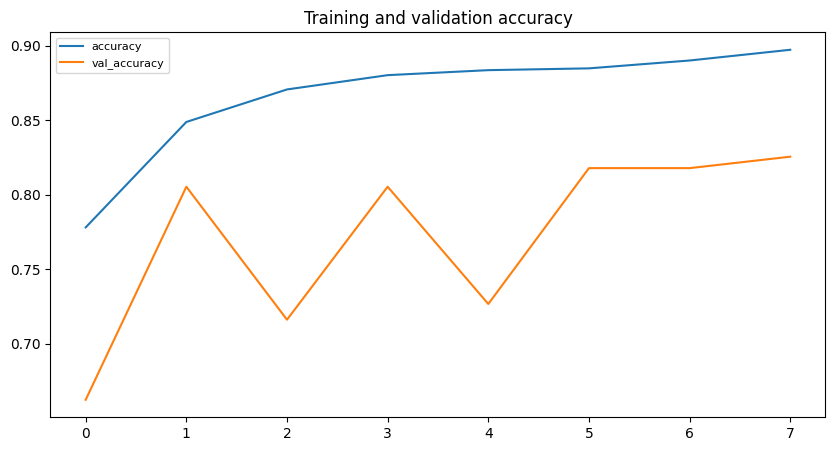

In [11]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)


Text(0.5, 1.0, 'Training and validation precision')

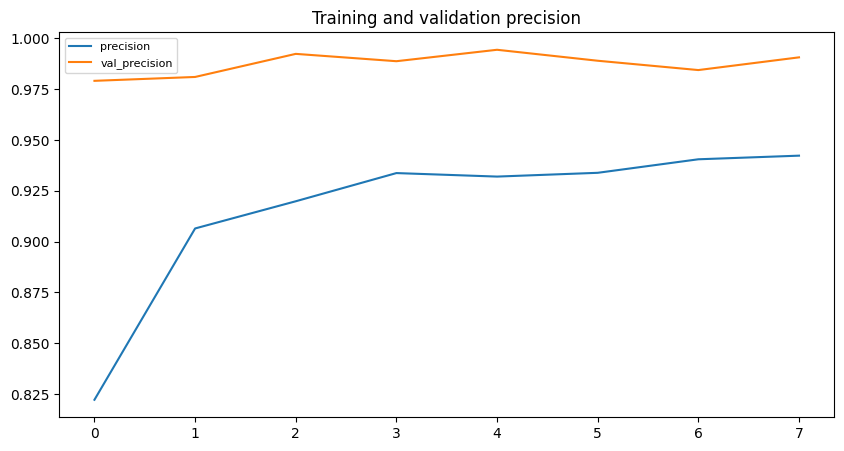

In [12]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

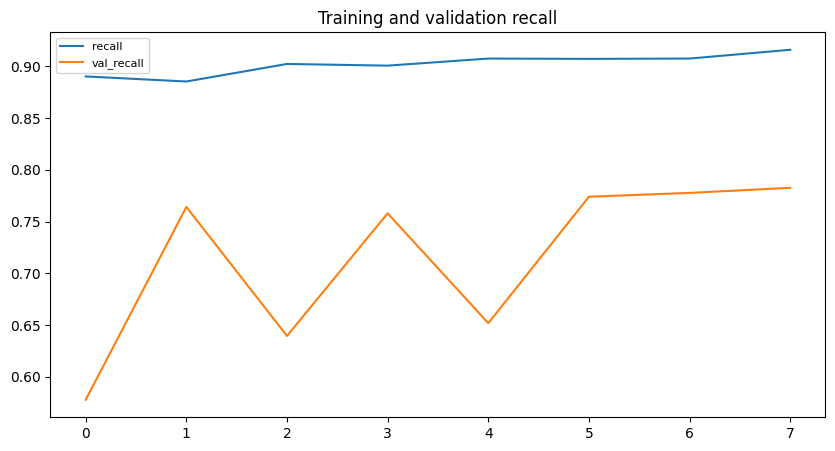

In [13]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [14]:
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.472304,0.778097,0.822236,0.890375,0.808565,0.551977,0.662512,0.979079,0.577778,0.903055
1,0.320156,0.848790,0.906480,0.885481,0.914749,0.436286,0.805369,0.980983,0.764198,0.927076
2,0.289484,0.870597,0.919854,0.902447,0.930698,0.498435,0.716203,0.992337,0.639506,0.937964
3,0.276367,0.880182,0.933717,0.900816,0.937689,0.423151,0.805369,0.988728,0.758025,0.943175
4,0.263440,0.883537,0.931993,0.907667,0.942067,0.457204,0.726750,0.994350,0.651852,0.947112
5,0.260994,0.884735,0.933848,0.907341,0.943589,0.352436,0.817833,0.988959,0.774074,0.947078
6,0.255338,0.890007,0.940500,0.907667,0.946797,0.385414,0.817833,0.984375,0.777778,0.948063
7,0.243027,0.897196,0.942282,0.916150,0.952479,0.344589,0.825503,0.990625,0.782716,0.950612


In [15]:
model.evaluate(test_dataset)

7/7 [==============================] - 16s 2s/step - loss: 0.4710 - accuracy: 0.7740 - precision: 0.8356 - recall: 0.7949 - auc: 0.8535


[0.4709615409374237,
 0.7740384340286255,
 0.835579514503479,
 0.7948718070983887,
 0.8534571528434753]

In [61]:
img_arrays = []
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  img_arrays = img_arrays + tf.unstack(x)
  prediction_prob = model.predict(x).flatten()
  predictions = np.concatenate([predictions, tf.where(prediction_prob < 0.5, 0, 1)])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 1s 593ms/step


In [62]:
len(img_arrays)

624

In [50]:
len(predictions)

624

In [51]:
len(labels)

624

In [78]:
test_true_positives = np.where((labels == 1) & (predictions == 1))[0]
test_false_positives = np.where((labels == 0) & (predictions == 1))[0]
test_true_negatives = np.where((labels == 0) & (predictions == 0))[0]
test_false_negatives = np.where((labels == 1) & (predictions == 0))[0]

In [79]:
print(len(test_true_positives))
print(len(test_false_positives))
print(len(test_true_negatives))
print(len(test_false_negatives))

310
61
173
80


In [82]:
test_true_positives

array([  0,   6,   7,   9,  10,  15,  19,  20,  22,  28,  30,  31,  35,
        36,  38,  43,  44,  50,  51,  53,  55,  56,  57,  58,  60,  65,
        67,  69,  71,  72,  76,  77,  78,  83,  84,  85,  86,  87,  88,
        89,  90,  92,  93,  97,  98, 102, 103, 106, 107, 108, 109, 110,
       111, 112, 113, 115, 116, 119, 122, 123, 129, 130, 131, 135, 136,
       140, 141, 142, 143, 147, 149, 151, 153, 154, 156, 157, 160, 161,
       162, 163, 164, 165, 168, 170, 171, 173, 174, 175, 176, 181, 182,
       183, 184, 185, 186, 187, 191, 192, 194, 195, 198, 199, 200, 201,
       202, 204, 207, 208, 211, 212, 221, 222, 227, 229, 230, 231, 239,
       241, 242, 243, 245, 248, 250, 252, 253, 254, 255, 256, 257, 258,
       260, 261, 262, 264, 266, 268, 269, 270, 272, 273, 274, 275, 276,
       280, 284, 285, 287, 289, 290, 291, 292, 293, 295, 297, 300, 302,
       303, 307, 308, 316, 317, 318, 319, 321, 322, 324, 327, 328, 331,
       332, 333, 334, 339, 340, 342, 346, 349, 351, 352, 353, 35

In [80]:
test_outcomes_dict = {"True Positives":test_true_positives,
                        "False Positives": test_false_positives,
                        "True Negatives": test_true_negatives, 
                        "False Negatives": test_false_negatives}

In [91]:
sample_img_indexes = list(np.random.choice(test_outcomes_dict["True Positives"], size=9))
sample_img_indexes

[388, 332, 51, 459, 136, 86, 454, 496, 116]

In [92]:
sample_test_img_arrays = [img_arrays[i] for i in sample_img_indexes]
sample_test_img_arrays

[<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[212.15753  , 212.15753  , 212.15753  ],
         [206.79272  , 206.79272  , 206.79272  ],
         [ 47.841198 ,  47.841198 ,  47.841198 ],
         ...,
         [ 41.83932  ,  41.83932  ,  41.83932  ],
         [ 39.92871  ,  39.92871  ,  39.92871  ],
         [ 35.07461  ,  35.07461  ,  35.07461  ]],
 
        [[211.       , 211.       , 211.       ],
         [202.9981   , 202.9981   , 202.9981   ],
         [ 56.60716  ,  56.60716  ,  56.60716  ],
         ...,
         [ 48.702248 ,  48.702248 ,  48.702248 ],
         [ 40.753716 ,  40.753716 ,  40.753716 ],
         [ 39.30357  ,  39.30357  ,  39.30357  ]],
 
        [[211.5912   , 211.5912   , 211.5912   ],
         [194.64285  , 194.64285  , 194.64285  ],
         [139.92093  , 139.92093  , 139.92093  ],
         ...,
         [ 52.053642 ,  52.053642 ,  52.053642 ],
         [ 46.60728  ,  46.60728  ,  46.60728  ],
         [ 37.591167 ,  37.591167 ,  37.591167

In [98]:
sample_test_prediction_probabilities = [model.predict(np.expand_dims(img_array, axis=0))[0][0] for img_array in sample_test_img_arrays]
sample_test_prediction_probabilities

1/1 [==============================] - 0s 86ms/step


[0.888433,
 0.9504935,
 0.8535057,
 0.80057967,
 0.52366483,
 0.9408239,
 0.9638259,
 0.90180284,
 0.93559086]

In [100]:
sample_test_labels = labels[sample_img_indexes]
sample_test_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

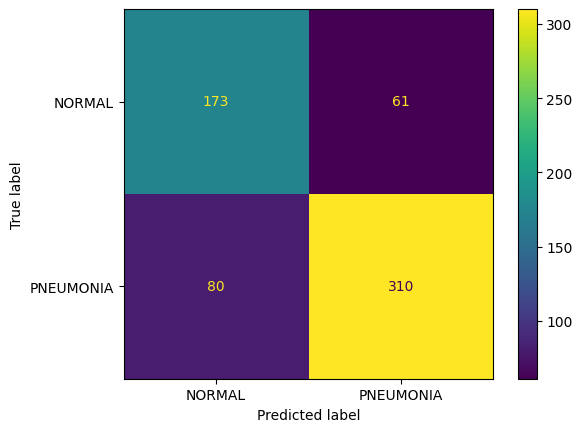

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(labels, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot()
plt.show()

In [75]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [76]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))[-1].name
last_conv_layer_name

'Conv_1'

In [20]:
import matplotlib.cm as cm

img_array = img_arrays[0][0]
img_tensor = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
heatmap = np.uint8(255 * heatmap)
heatmap

array([[142,  76,  97,   0,  38,  49, 165],
       [ 50,   0,  69,   0,   2,   0, 132],
       [  0,   0,   0,   0,   2,  17, 182],
       [  0,   0,   0,   0,  69, 153, 255],
       [  0,   0,   0,   0,   0,   0, 133],
       [  0,   0,   0,   0,   0,   0,  35],
       [  0,   0,   0,   0,   0,   0,   0]], dtype=uint8)

C:\Users\angus\AppData\Local\Temp\ipykernel_30128\592816440.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


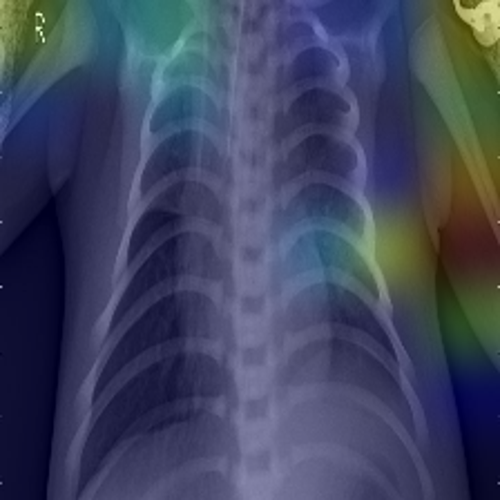

In [21]:
img_array = img_arrays[0][0]
img_tensor = np.expand_dims(img_array, axis=0)
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
heatmap = np.uint8(255 * heatmap)
heatmap

# Create an image with RGB colorized heatmap
img_array_resized = tf.keras.preprocessing.image.array_to_img(img_array)
img_array_resized = img_array_resized.resize((500, 500))
img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)


jet = cm.get_cmap("jet")
# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array_resized.shape[0], img_array_resized.shape[1]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img_array_resized
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

1/1 [==============================] - 0s 86ms/step


C:\Users\angus\AppData\Local\Temp\ipykernel_30128\285456560.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 57ms/step


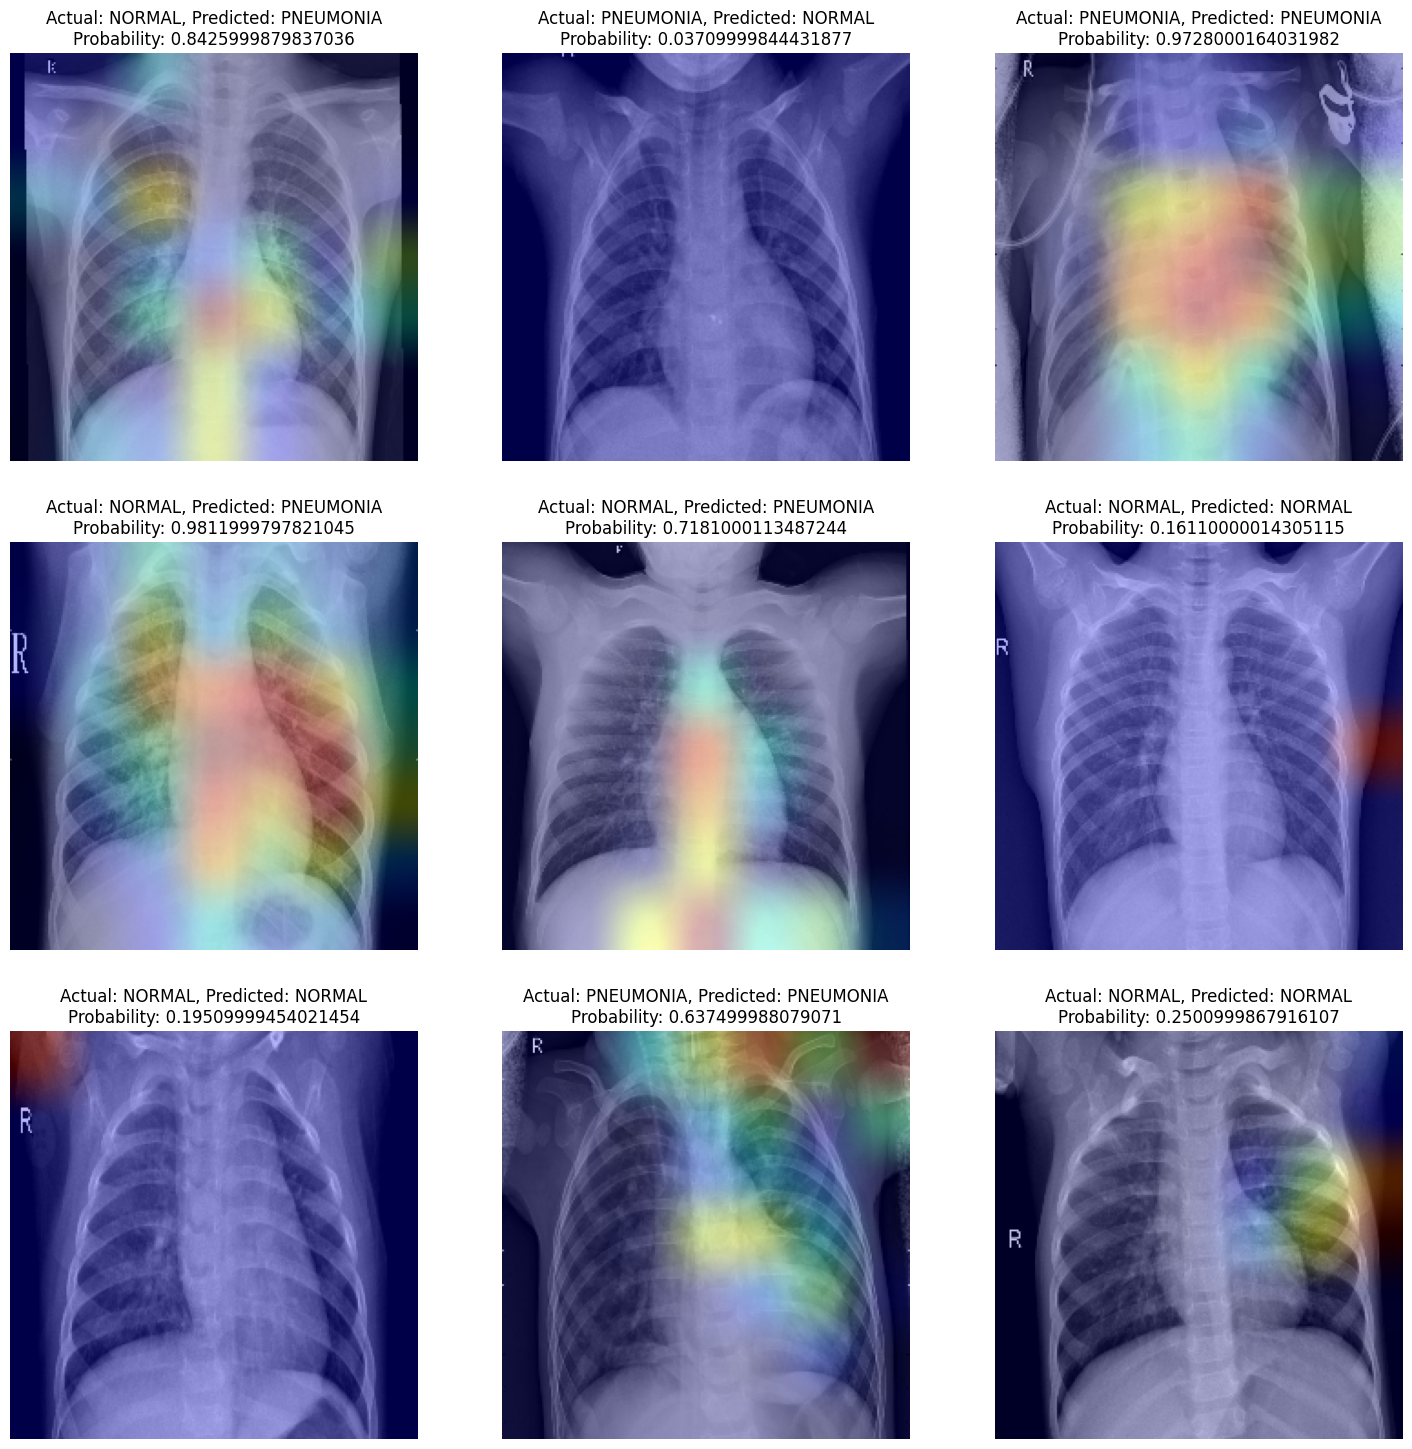

In [48]:
import matplotlib.cm as cm
random_img_arrays = np.random.randint(99, size=9)

fig, axes = plt.subplots(3,3, figsize=(18,18))

for i in range(len(random_img_arrays)):

    img_array = np.expand_dims(img_arrays[0][random_img_arrays[i]], axis=0)
    prediction_prob = model.predict(img_array)
    prediction = np.where(prediction_prob[0] < 0.5, "NORMAL", "PNEUMONIA")[0]
    label = "PNEUMONIA" if labels[random_img_arrays[i]] == 1 else "NORMAL"

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[2]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.squeeze(img_array)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    axes[i//3, i%3].imshow(superimposed_img)
    axes[i//3, i%3].set_title(f"Actual: {label}, Predicted: {prediction}\nProbability: {round(prediction_prob[0][0],4)}")
    axes[i//3, i%3].axis('off')

plt.show()

